<a href="https://colab.research.google.com/github/mostafa-ja/Transformers/blob/main/Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
[kaggle tutorial link](https://www.kaggle.com/code/arunmohan003/transformer-from-scratch-using-pytorch/notebook)



#  Import Libraries




In [2]:
# importing required libraries
import torch.nn as nn
import torch
import torch.nn.functional as F
import math,copy,re
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import torchtext
import matplotlib.pyplot as plt
warnings.simplefilter("ignore")
print(torch.__version__)

1.13.1+cu116


# Basic components

Create Word Embeddings

First of all we need to convert each word in the input sequence to an embedding vector. Embedding vectors will create a more semantic representation of each word.

Suppoese each embedding vector is of 512 dimension and suppose our vocab size is 100, then our embedding matrix will be of size 100x512. These marix will be learned on training and during inference each word will be mapped to corresponding 512 d vector. Suppose we have batch size of 32 and sequence length of 10(10 words). The the output will be 32x10x512.

In [3]:
class Embedding(nn.Module):
  def __init__(self,vocab_size,embed_dim):
    super(Embedding,self).__init__()
    self.embed = nn.Embedding(vocab_size,embed_dim)

  def forward(self,x):
    out = self.embed(x)
    return out

# Positional Encoding

Positinal embedding will generate a matrix of similar to embedding matrix. It will create a matrix of dimension sequence length x embedding dimension. For each token(word) in sequence, we will find the embedding vector which is of dimension 1 x 512 and it is added with the correspondng positional vector which is of dimension 1 x 512 to get 1 x 512 dim out for each word/token.

for eg: if we have batch size of 32 and seq length of 10 and let embedding dimension be 512. Then we will have embedding vector of dimension 32 x 10 x 512. Similarly we will have positional encoding vector of dimension 32 x 10 x 512. Then we add both

In [9]:
# register buffer in Pytorch ->
# If you have parameters in your model, which should be saved and restored in the state_dict,
# but not trained by the optimizer, you should register them as buffers.


class PositionalEmbedding(nn.Module):
    def __init__(self,max_seq_len,embed_dim):
        super().__init__()
        self.embed_dim = embed_dim 
        assert embed_dim % 2 == 0 ,'embed_dim must be even'
        pe = torch.zeros(max_seq_len,embed_dim)
        for pos in range(max_seq_len):
            for i in range(0,embed_dim,2):
                pe[pos, i] = math.sin(pos / (10000 ** ((2 * i)/embed_dim)))
                pe[pos, i + 1] = math.cos(pos / (10000 ** ((2 * (i + 1))/embed_dim))) #i have doubt about (i+1) or (i)
        pe = pe.unsqueeze(0) #shape:(1,max_seq_len,embed_dim)
        self.register_buffer('pe', pe)


    def forward(self, x):      
        seq_len = x.size(1)
        x = x + self.pe[:,:seq_len] #shape:(1,seq_len,embed_dim)
        return x

# Self Attention

**Step 1**: The first step in calculating self-attention is to create three vectors from each of the encoder’s input vectors (in this case, the embedding of each word). So for each word, we create a Query vector, a Key vector, and a Value vector. Each of the vector will be of dimension 1x64.

Suppose we have batch_size=32,sequence_length=10, embedding dimension=512. So after embedding and positional encoding our output will be of dimension 32x10x512.
We will resize it to 32x10x8x64.(About 8, it is the number of heads in multihead attention.Dont worry you will get to know about it once you go through the code.).

**Step 2**: Second step is to calculate the score. ie, we will multiply query marix with key matrix. [Q x K.t]

Suppose our key,query and value dimension be 32x10x8x64. Before proceeding further, we will transpose each of them for multiplication convinience (32x8x10x64). Now multiply query matrix with transpose key matrix. ie (32x8x10x64) x (32x8x64x10) -> (32x8x10x10).

**Step 3:** Now divide the output matrix with square root of dimension of key matrix and then apply Softmax over it.

we will divide 32x8x10x10 vector by 8 ie, by square root of 64 (dimension of key matrix)

**Step 4:** Then this gets multiply it with value matrix.

After step 3 our output will be of dimension 32x8x10x10. Now muliply it with value matrix (32x8x10x64) to get output of dimension (32x8x10x64).Here 8 is the number of attention heads and 10 is the sequence length.Thus for each word we have 64 dim vector.

**Step 5**: Once we have this we will pass this through a linear layer. This forms the output of multihead attention.

(32x8x10x64) vector gets transposed to (32x10x8x64) and then reshaped as (32x10x512).Then it is passed through a linear layer to get output of (32x10x512).

A ‘View’ uses the same chunk of memory block as the original tensor, and thus any changes among this memory chunk will affect all the views and the original tensor that’s associated with it.  

Transpose( ) has Non-Contiguous Data Structure

A non-contiguous tensor view can be converted to a contiguous one, and it would make a copy of it, so the data will not be associated with the original data chunk anymore.

Difference between view() and reshape():

**view() cannot apply on ‘non-contiguous’ tensor** for example after using transpose we cannot use view unless we make it contigous(define new arrange of elemnts in matrice which is diffrent from the first diffinition like the below pic).

reshape() can apply on both ‘contiguous’ and ‘non-contiguous’ tensor/view. When possible, it will return a view; When the data is non-contiguous, it makes a new copy of it.

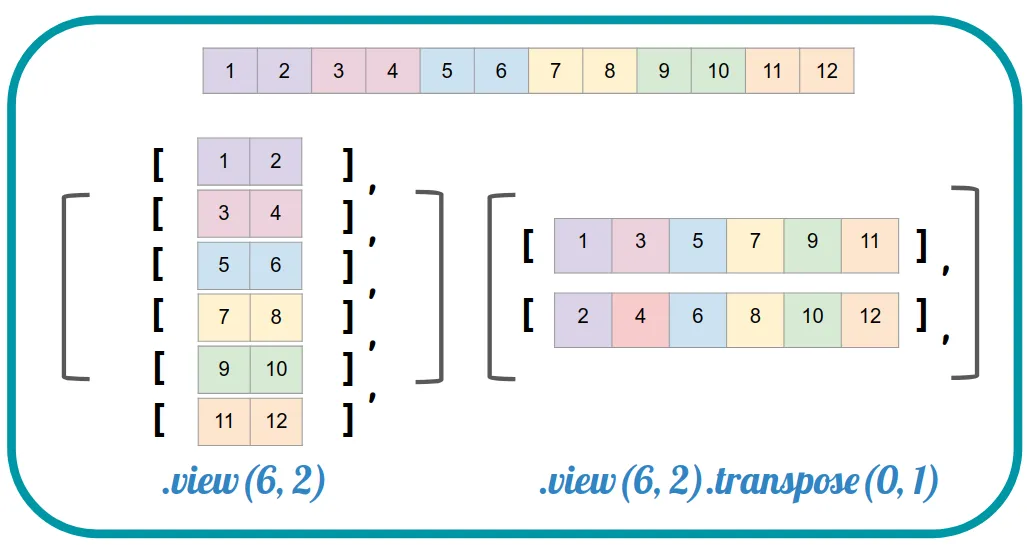

In [ ]:
class MultiHeadAttention(nn.Module):
  def __init__(self, embed_dim=512, n_heads=8):
    super().__init__()
    self.embed_dim = embed_dim    #512 dim
    self.n_heads = n_heads   #8
    self.single_head_dim = int(self.embed_dim / self.n_heads)   #512/8 = 64  . each key,query, value will be of 64d

    #key,query and value matrixes    #64 x 64 
    self.query_matrix = nn.Linear(self.single_head_dim, self.single_head_dim, bias=False)
    self.key_matrix = nn.Linear(self.single_head_dim, self.single_head_dim, bias=False)
    self.value_matrix = nn.Linear(self.single_head_dim, self.single_head_dim, bias=False)

    self.out = nn.Linear(self.n_heads*self.single_head_dim ,self.embed_dim) # or (self.embed_dim,self.embed_dim)

  def forward(self,key, query, value, mask=None): #batch_size x sequence_length x embedding_dim    # 32 x 10 x 512
    batch_size = key.size(0)
    seq_length = key.size(1)

    # 32x10x512
    key = key.view(batch_size, seq_length, self.n_heads, self.single_head_dim)  #batch_size x sequence_length x n_heads x single_head_dim = (32x10x8x64)
    query = query.view(batch_size, seq_length, self.n_heads, self.single_head_dim) #(32x10x8x64)
    value = value.view(batch_size, seq_length, self.n_heads, self.single_head_dim) #(32x10x8x64)
    
    k = self.key_matrix(key)       # (32x10x8x64)
    q = self.query_matrix(query)   
    v = self.value_matrix(value)

    q = q.transpose(1,2)  # (batch_size, n_heads, seq_len, single_head_dim)    # (32 x 8 x 10 x 64)
    k = k.transpose(1,2)  # (batch_size, n_heads, seq_len, single_head_dim)
    v = v.transpose(1,2)  # (batch_size, n_heads, seq_len, single_head_dim)

    # computes attention
    # adjust key for matrix multiplication
    k_adjusted = k.transpose(-1,-2)  #(batch_size, n_heads, single_head_dim, seq_ken)  #(32 x 8 x 64 x 10)
    product = torch.matmul(q, k_adjusted)  #(32 x 8 x 10 x 64) x (32 x 8 x 64 x 10) = #(32x8x10x10)

    # fill those positions of product matrix as (-1e20) where mask positions are 0
    if mask is not None:
          product = product.masked_fill(mask == 0, float("-1e20"))

    #divising by square root of key dimension
    product = product / math.sqrt(self.single_head_dim) # / sqrt(64)

    #applying softmax
    scores = F.softmax(product, dim=-1)

    #mutiply with value matrix
    scores = torch.matmul(scores, v)  ##(32x8x 10x 10) x (32 x 8 x 10 x 64) = (32 x 8 x 10 x 64) 

    #concatenated output
    concat = scores.transpose(1,2).contiguous().view(batch_size, seq_length, self.single_head_dim*self.n_heads)  # (32x8x10x64) -> (32x10x8x64)  -> (32,10,512)
    #after transpose , the tensor will be not contiguous, so we cannot use view() after that unless we first make it contaguous then use view
    #contaguous means that for example we have a tensor:[1,2,...,10] with changing shape into (2,5) the order does not change but if we use transpose ,
    #the main order will get mixed up(check the top pic) so we need to define again the order by  contiguous()

    output = self.out(concat) #(32,10,512) -> (32,10,512)
       
    return output
